# Импорт библиотек

In [ ]:
# Работа с данными
import pandas as pd
import numpy as np
# Визуализация
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.transforms import Bbox
import seaborn as sns
palette = plt.get_cmap('Set2')
plt.style.use('seaborn-darkgrid')
# Алгоритмы ML
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
# Паралельные вычисления
import asyncio
import nest_asyncio
nest_asyncio.apply()
asyncio.set_event_loop(asyncio.new_event_loop())
# Игнор предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Данные можно скачать по ссылке:

products: https://drive.google.com/file/d/1t9rE72jB6KcMZc8_jSGvkIeRhdYrksbu/view?usp=share_link

transactions: https://drive.google.com/file/d/1_m5yIoxXrImRSi5UOLmWI5R8oFDCg1vp/view?usp=share_link

In [ ]:
# Импорт и разархивация сырых данных
! 7z x /content/drive/MyDrive/graduate_work/recommender_system/products.csv.zip
! 7z x /content/drive/MyDrive/graduate_work/recommender_system/transactions.csv.zip

# Работа с данными

Откроем таблицы в формате DataFrame и для удобства объединим их

In [ ]:
products = pd.read_csv('products.csv', sep = ',')
trans = pd.read_csv('transactions.csv', sep = ',')

df = trans.merge(products[['product_id', 'aisle_id', 'department_id']], on = 'product_id')

Понизим размерность числовых данных с 64 бит до 32

In [ ]:
for col in df.columns: 
    if isinstance(df[col].iloc[0], np.int64):
        df[col] = df[col].astype(np.int32)   
    elif isinstance(df[col].iloc[0], np.float64):
        df[col] = df[col].astype(np.float32)   
    else:
        continue

Поделим данные на тренеровочные и тестировочные для оффлан проверки метрики MAP@10

Делить будем на основе записей покупок, так в тестировочной выборку будут только последнии покупки, а в тренеровочных все остальные

In [ ]:
df = df.merge(df.groupby('user_id')['order_number'].max().reset_index().rename(columns = {'order_number': 'last_order'}), on = 'user_id')
df_train, df_test = df[~df['order_number'].eq(df['last_order'])], df[df['order_number'].eq(df['last_order'])]

Сохраним в формате CVS

In [ ]:
for data, file_name in zip((df, df_train, df_test), ('main_data','train', 'test')):
    data.to_csv(f'{file_name}.csv', index=False)

del df, df_train, df_test, data, products

Используя агрегирование получим новые признаки для продуктов и соберем матрицу признаков

In [ ]:
# Загрузим тренеровочный датафрейм
df = pd.read_csv('train.csv')

# Агрегируем данные
df_agg = df.groupby(['product_id', 'aisle_id', 'department_id'])\
           .agg({
                 'user_id': 'nunique' # Сколько человек купили продукт
                ,'order_dow': 'median' # Медианный день недели покупки
                ,'order_hour_of_day': 'median' # Медианное время покупки
                ,'days_since_prior_order': 'mean' # Среднее между временем покупок
                ,'add_to_cart_order': 'median' # Среднее по корзине
                ,'reordered': 'sum' # Сумма повторных покупок
        }).reset_index().rename(
                            columns={
                                 'user_id': 'n_users'
                                ,'order_dow': 'median_dow'
                                ,'order_hour_of_day': 'median_hour_of_day'
                                ,'days_since_prior_order': 'mean_days_between_orders'
                                ,'add_to_cart_order': 'median_cart_position'
                                ,'reordered': 'total_reordered'})

df_agg.head()

,product_id,aisle_id,department_id,n_users,median_dow,median_hour_of_day,mean_days_between_orders,median_cart_position,total_reordered
0,1,61,19,485,3.0,13.0,8.918789,4.0,1008.0
1,2,104,13,63,3.0,13.0,9.647887,9.0,10.0
2,3,94,7,51,2.0,11.0,9.296460,4.5,187.0
3,4,38,1,104,2.0,14.0,12.566845,8.0,96.0
4,5,5,13,3,2.0,11.0,11.090909,6.0,8.0


In [ ]:
# Запишем продукты входящие в первую покупку (mean_days_between_orders = Nan)
exceptions = df_agg[pd.isna(df_agg['mean_days_between_orders'])]['product_id'].values

# Выделим категориальные данные
num_cols = ['n_users', 'mean_days_between_orders', 'median_cart_position', 'total_reordered']
cat_cols = ['aisle_id', 'department_id', 'median_dow', 'median_hour_of_day']
for col in cat_cols:
    df_agg[col] = df_agg[col].astype(np.int32).astype(str) # Категодиальные в строковые

# Разделим на датафреймы подлежащие кластеризации и не подлежащие
df_agg_main = df_agg[~df_agg['product_id'].isin(exceptions)]
df_agg_exc = df_agg[df_agg['product_id'].isin(exceptions)]

del df, df_agg

In [ ]:
# Создадим матрицу признаков
num_features = df_agg_main[num_cols]
cat_features = pd.get_dummies(df_agg_main[cat_cols])

cols = num_features.columns.tolist() + cat_features.columns.tolist()

x = np.hstack([num_features.values.reshape(df_agg_main.shape[0], -1),
               cat_features.values.reshape(df_agg_main.shape[0], -1)])

del num_features, cat_features

# Кластеризация данных

Найдем оптимальное кол-во кластеров для кашего спискаа продуктов

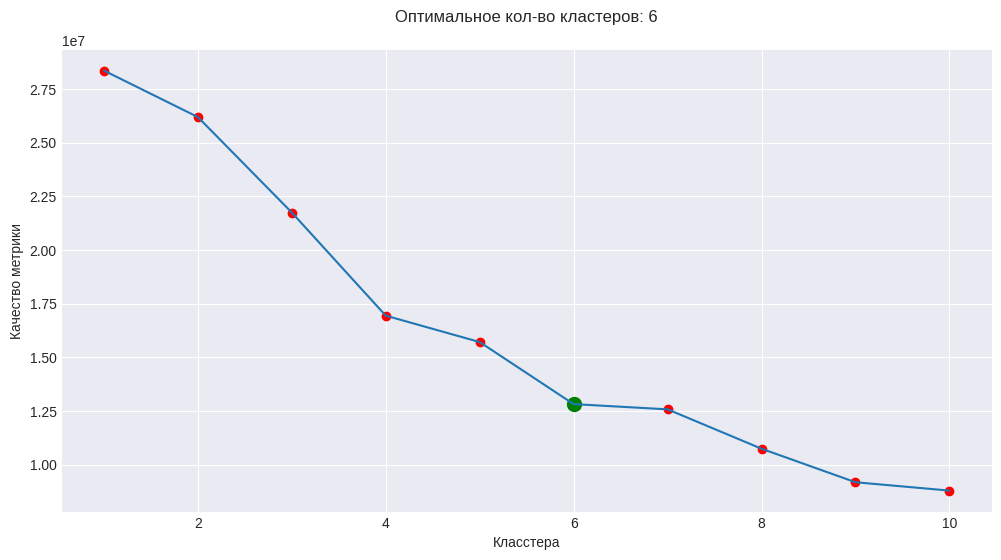

In [ ]:
k_limit = 10

models = {key: None for key in range(1, k_limit + 1)}
metrics = {key: None for key in range(1, k_limit + 1)}

for k in range(1, k_limit + 1):
    models[k] = KMeans(n_clusters=k, random_state=17).fit(x)
    centroids, labels = models[k].cluster_centers_, models[k].labels_
    
    metric = 0
    for centroid in range(k):
        metric += euclidean_distances(x[labels==centroid], centroids[centroid,:].reshape(1, -1)).sum(axis=0)[0]
    
    metrics[k] = metric
    
D = {k: abs(metrics.get(k + 1, 0) - metrics[k]) / abs(metrics[k]- metrics.get(k - 1, 0)) for k in range(2, k_limit + 1)}

best_k = min(D.items(), key=lambda x: x[1])[0]


# Визуализируем
plt.figure(figsize = (12, 6))

x_ = np.arange(1, 11)
y_ = [v for k, v in metrics.items()]

plt.plot(x_, y_)
plt.scatter(x_, y_, color = 'red')
plt.scatter(x_[5], y_[5], color = 'green', s = 100)

plt.title(f'Оптимальное кол-во кластеров: {best_k}', pad = 20)
plt.ylabel('Качество метрики')
plt.xlabel('Класстера')
plt.show()

Используя лучшую модель кластеризируем данные и добавим новую колонку с класерами для каждого продукта

In [ ]:
# Инициализируем лучшую модель
best_model = models[best_k]

# Расчитаем метрику
score = silhouette_score(x, best_model.labels_)
print(f'Метрика по силуету: {score:.3f}')

# Добавим в датафрейм кластера продуктов
df_agg_main['Cluster'] = best_model.labels_

# Сохраним центроиды
centroids = pd.DataFrame(data={col: cluster for col, cluster in zip(cols, best_model.cluster_centers_.T)}, 
                         index=range(df_agg_main['Cluster'].nunique()))

Метрика по силуету: 0.920


Визуализируем кластеризированные данные понизив размернось признаков до двух

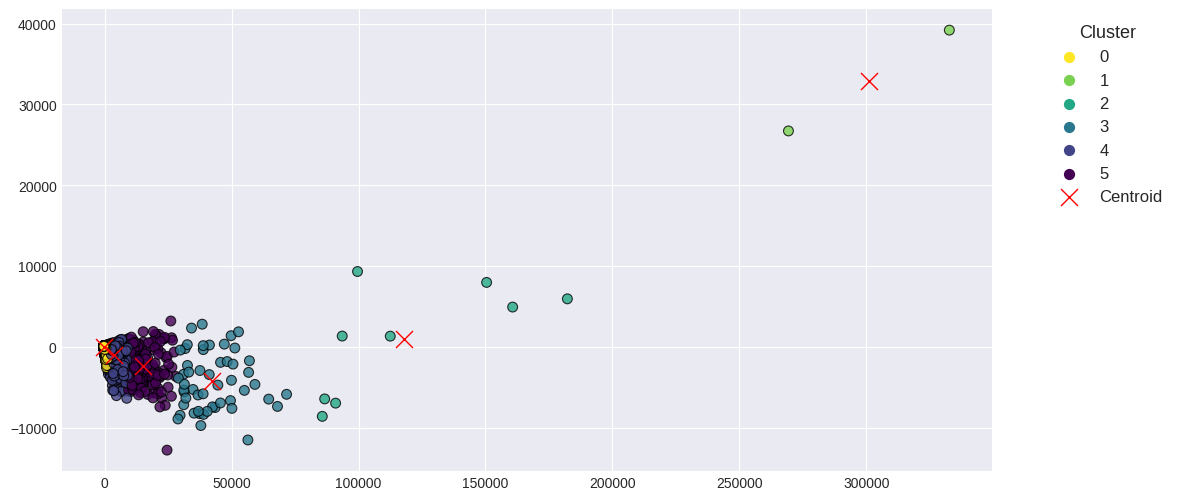

In [ ]:
# Приведем данные в двумерный массив
pca = PCA(n_components=2).fit(x)
x_pca = pca.transform(x)
centroids_pca = pca.transform(centroids.values)

# Визуализируем
fig, ax = plt.subplots(figsize=(12, 6))

sns.scatterplot(x = x_pca[:, 0], y = x_pca[:, 1], hue = best_model.labels_,
                alpha = 0.8, palette = 'viridis_r', edgecolor = 'black', linewidth = .8, size = best_model.labels_, sizes = (50, 50), ax = ax)


sns.scatterplot(x = centroids_pca[:, 0], y = centroids_pca[:, 1], 
                color = 'red', label = 'Centroid', linewidth = 1.0, marker = 'x', s=150, ax = ax)

ax.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=12)
ax.legend_.set_title('Cluster')
ax.legend_.get_title().set_fontsize(13)

plt.show()

# Финальная подготовка эмбеддингов

In [ ]:
# Добавим отдельный кластер для исключений
df_agg_exc['Cluster'] = -1

# Собираем общий датафрейм с ембеддингами
prod_emb = (pd.concat([df_agg_main, df_agg_exc], ignore_index=True)).reset_index().assign(indx=lambda x: x.index)

prod_emb = prod_emb[['indx', 'product_id'] + num_cols]\
                                                .join(pd.get_dummies(prod_emb[cat_cols]))\
                                                .join(pd.get_dummies(prod_emb['Cluster']))

prod_emb.to_csv('product_embedding.csv', index=False)

del x, df_agg_main, df_agg_exc, prod_emb

# Поиск соседей для продуктов

In [ ]:
# Загрузим датафрейм с эмбеддинами
prod_emb = pd.read_csv('product_embedding.csv')

Используя агоритм NearestNeighbors из библиотеки sklearn обучим его и получим 10 ближайших соседей для каждого продукта

In [ ]:
# Обучаем алгоритм NearestNeighbors
emb_cols = prod_emb.columns[2:]
prod_emb.fillna(prod_emb['mean_days_between_orders'].median(), inplace=True)

neigh = NearestNeighbors(n_jobs=-1, metric='euclidean').fit(prod_emb[emb_cols].values)

In [ ]:
%%time

# Собираем топ 10 соседей для каждого продукта

tmp_res_list = []

async def knn(prod_id:int, k:int=10):
    
    neighbors = neigh.kneighbors(
                             prod_emb[prod_emb['product_id'].eq(prod_id)][emb_cols].values
                            ,n_neighbors=k
                            ) 
    tmp = pd.DataFrame({
                     'product_id_x': [prod_id] * k
                    ,'indx': neighbors[1][0]
                    ,'Metric': neighbors[0][0]
            
        })   
    tmp_res_list.append(tmp)
    
async def main(k:int=10):

    tasks = [asyncio.create_task(knn(prod, k)) for prod in prod_emb['product_id'].values]

    await asyncio.gather(*tasks)

loop = asyncio.get_event_loop()
loop.run_until_complete(main(10))

loop.run_until_complete(loop.shutdown_asyncgens())
    
prod_knn_df = pd.DataFrame()
for elem in tmp_res_list:
    prod_knn_df = pd.concat([prod_knn_df, elem], ignore_index=True)

prod_knn_df.to_csv(f'product_knn_{10}.csv', index=False)
    
del tmp_res_list, prod_knn_df
    
asyncio.set_event_loop(asyncio.new_event_loop())

CPU times: user 40min 7s, sys: 8.73 s, total: 40min 15s
Wall time: 25min 25s


# Обработка пользователей

In [ ]:
# Выгружаем датафреймы
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
# Получаем список покупателей
users = np.sort(df_train ['user_id'].unique())

In [ ]:
# Агрегируем данные по транзакциям
user_ex = df_train[df_train['user_id'].eq(1)].assign(dummy=1)\
                                             .groupby(['user_id', 'product_id'])\
                                             .agg({'dummy': 'sum'})\
                                             .assign(weight=lambda x: x.dummy )\
                                             .sort_values(['user_id', 'weight'], ascending=False)\
                                             .reset_index()\
                                             .groupby('user_id')\
                                             .apply(lambda x: x.iloc[: 10])[['user_id', 'product_id', 'weight']]

user_ex

user_id  product_id  weight
user_id                               
1       0        1         196       9
        1        1       12427       9
        2        1       10258       8
        3        1       25133       7
        4        1       13032       2
        5        1       13176       2
        6        1       26088       2
        7        1       26405       2
        8        1       46149       2
        9        1       49235       2

In [ ]:
# С помощью ранее записанного файла с соседями для продукта находим для каждого топ 10 соседей

knn_ex = pd.read_csv(f'product_knn_{10}.csv')   
knn_ex = knn_ex.merge(prod_emb, on='indx')[['product_id_x', 'product_id', 'Metric']]\
                                        .rename(columns={'product_id_x': 'product_id', 'product_id': 'product_id_y'})

knn_ex.head()

,product_id,product_id_y,Metric
0,1,1,0.000000
1,1804,1,25.885248
2,8381,1,13.245820
3,13447,1,6.222959
4,20906,1,15.544019


# Финальная подборка рекомендаций

In [ ]:
# С помощью метода взвешенного растояния находим топ 10 товаров для каждого пользователя

out = user_ex.merge(knn_ex, on='product_id')[['user_id', 'product_id', 'weight', 'product_id_y', 'Metric']]
    
out['Metric'] = (out['Metric'] + 1) / out['weight']
        
out = out.sort_values(['user_id', 'Metric'], ascending=True)\
                                            .reset_index()\
                                            .groupby('user_id')\
                                            .apply(lambda x: x.iloc[: 10])\
                                            .rename(columns={'user_id': 'user_id_y'})\
                                            .groupby('user_id_y')['product_id_y'].agg(list).values

In [ ]:
def get_users_history(data:pd.DataFrame, users:(list, np.ndarray), k:int=10) -> pd.DataFrame:
    
    """ Возвращает топ 10 товаров для каждого покупателя на основе историй покупок сортируя их """
    
    out = data[data['user_id'].isin(users,)].assign(dummy=1)\
                                            .groupby(['user_id', 'product_id'])\
                                            .agg({'dummy': 'sum'})\
                                            .assign(weight=lambda x: x.dummy )\
                                            .sort_values(['user_id', 'weight'], ascending=False)\
                                            .reset_index()\
                                            .groupby('user_id')\
                                            .apply(lambda x: x.iloc[: k])[['user_id', 'product_id', 'weight']]
    
    return out

##############################################################

def get_products_neighbors(k:int=10) -> pd.DataFrame:
    
    """ Возвращает датафрейм с 10 соседями для каждого продукта """
    
    out = pd.read_csv(f'product_knn_{k}.csv')   
    out = out.merge(prod_emb, on='indx')[['product_id_x', 'product_id', 'Metric']]\
                                        .rename(columns={'product_id_x': 'product_id', 'product_id': 'product_id_y'})
    
    return out

##############################################################

def predict(data:pd.DataFrame, users:(list, np.ndarray), k:int=10) -> pd.Series:
    
    """ Возвращает топ 10 рекомендаций для каждого покупателя """
    
    user_hist = get_users_history(data=data, users=users, k=k)  
    prod_neigh = get_products_neighbors(k=k)
    
    out = user_hist.merge(prod_neigh, on='product_id')[['user_id', 'product_id', 'weight', 'product_id_y', 'Metric']]
    
    out['Metric'] = (out['Metric'] + 1) / out['weight']
        
    out = out.sort_values(['user_id', 'Metric'], ascending=True)\
                                            .reset_index()\
                                            .groupby('user_id')\
                                            .apply(lambda x: x.iloc[: k])\
                                            .rename(columns={'user_id': 'user_id_y'})\
                                            .groupby('user_id_y')['product_id_y'].agg(list)
    
    return out

################################################################

# Evaluation metric

def precision(arr1:(list, np.ndarray), arr2:(list, np.ndarray), n:int=10) -> float:
    
    """ Returns Precision@n score for two arrays """
    
    assert isinstance(arr1, (list, np.ndarray)) * isinstance(arr2, (list, np.ndarray)), 'Wrong type of input!'
    
    return len(set(arr1) & set(arr2)) / n

# Для Kaggle

In [ ]:
%%time

# Собираем список для Kaggle
result = pd.DataFrame(predict(df_train, users))
result = result.reset_index().rename(columns = {'user_id_y' : 'user_id', 'product_id_y' : 'product_id'})

CPU times: user 1min 48s, sys: 9.08 s, total: 1min 57s
Wall time: 2min 4s


In [ ]:
predict = result.product_id.to_list()

str_pred = []
for pred in predict:
  str_pred.append((' '.join([str(id) for id in pred])))

result['product_id'] = str_pred
result.to_csv('result.csv', index = False)

Метрика на Kaggle дала точность в 0.26 по MAP@10

### Оффлайн

In [ ]:
# Считаем оффлайн меторику
res = []
for user, arr1 in zip(pred.index, pred.values):
    arr2 = df_test[df_test['user_id'].eq(user)]['product_id'].values
    res.append(precision(arr1, arr2))
    
res = np.mean(res)
print(f'MAP@n score: {res:.3f}')

MAP@n score: 0.291
